In [1]:
import zipfile
import pandas as pd

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


import numpy as np
import pandas as pd
from numpy.linalg import cholesky

from utils.cholesky_rnn import *
from utils.cov_data_loader import CustomCovDataLoader

In [4]:
# Path to the ZIP file
zip_path = '../../data/Data_Cleaned.zip'

N_STOCKS = 5
DfLoader = CustomCovDataLoader(zip_path, n_first=N_STOCKS)
merged_df = DfLoader.load_data()
merged_df_minutely = DfLoader.transform_data(merged_df).copy()
merged_df_hourly = DfLoader.transform_data(merged_df, freq='1h').copy()

CSV files in the ZIP: ['Data_Cleaned/', 'Data_Cleaned/AAPL_1min_data_cleaned.csv', 'Data_Cleaned/AMGN_1min_data_cleaned.csv', 'Data_Cleaned/AXP_1min_data_cleaned.csv', 'Data_Cleaned/BA_1min_data_cleaned.csv', 'Data_Cleaned/CAT_1min_data_cleaned.csv', 'Data_Cleaned/CRM_1min_data_cleaned.csv', 'Data_Cleaned/CSCO_1min_data_cleaned.csv', 'Data_Cleaned/CVX_1min_data_cleaned.csv', 'Data_Cleaned/DIA_1min_data_cleaned.csv', 'Data_Cleaned/DIS_1min_data_cleaned.csv', 'Data_Cleaned/GS_1min_data_cleaned.csv', 'Data_Cleaned/HD_1min_data_cleaned.csv', 'Data_Cleaned/HON_1min_data_cleaned.csv', 'Data_Cleaned/IBM_1min_data_cleaned.csv', 'Data_Cleaned/INTC_1min_data_cleaned.csv', 'Data_Cleaned/JNJ_1min_data_cleaned.csv', 'Data_Cleaned/JPM_1min_data_cleaned.csv', 'Data_Cleaned/KO_1min_data_cleaned.csv', 'Data_Cleaned/MCD_1min_data_cleaned.csv', 'Data_Cleaned/MMM_1min_data_cleaned.csv', 'Data_Cleaned/MRK_1min_data_cleaned.csv', 'Data_Cleaned/MSFT_1min_data_cleaned.csv', 'Data_Cleaned/NKE_1min_data_cleaned

In [5]:
merged_df_hourly.head()

,AAPL_pret,AMGN_pret,AXP_pret,BA_pret,CAT_pret
timestamp,,,,,
2016-01-04 10:00:00,0.003001,-0.004973,-0.009797,-0.009855,-0.009396
2016-01-04 11:00:00,0.007348,-0.003013,-0.000445,-0.001396,0.000439
2016-01-04 12:00:00,0.004928,-0.000970,-0.000396,0.003360,0.003495
2016-01-04 13:00:00,0.009859,-0.002568,0.001584,0.002659,0.009019
2016-01-04 14:00:00,-0.002407,0.003336,-0.000247,-0.001610,0.012901


In [6]:
merged_df_hourly.shape

(14084, 5)

In [7]:
'''RMSE'''
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
    
'''Penalized RMSE'''
class SignSensitiveRMSELoss(nn.Module):
    def __init__(self, lambda_weight):
        super().__init__()
        self.mse = nn.MSELoss()
        self.lambda_weight = lambda_weight

    def forward(self, yhat, y):
        # Ensure yhat and y are tensors and their shapes are compatible
        assert isinstance(yhat, torch.Tensor), "yhat must be a tensor"
        assert isinstance(y, torch.Tensor), "y must be a tensor"
        assert yhat.shape == y.shape, "Shapes of yhat and y must match"

        # RMSE loss
        mse_loss = self.mse(yhat, y)  # MSE output is a scalar tensor
        rmse_loss = torch.sqrt(mse_loss)  # Apply sqrt to the scalar tensor

        # Reconstruct covariance matrices from true and predicted Cholesky factors
        def reconstruct_cov(cholesky_vec):
            batch_size = cholesky_vec.size(0)
            n = int((-1 + torch.sqrt(torch.tensor(1 + 8 * cholesky_vec.size(1), dtype=torch.float32))) // 2)
            L = torch.zeros(batch_size, n, n, device=cholesky_vec.device)
            tril_indices = torch.tril_indices(row=n, col=n, device=cholesky_vec.device)
            L[:, tril_indices[0], tril_indices[1]] = cholesky_vec
            return L @ L.transpose(1, 2)

        true_cov = reconstruct_cov(y)
        pred_cov = reconstruct_cov(yhat)

        # Sign-consistency penalty
        sign_diff = torch.sign(true_cov) - torch.sign(pred_cov)
        sign_penalty = torch.sum((sign_diff ** 2) / 4, dim=(1, 2))  # Penalize per matrix
        sign_penalty = torch.mean(sign_penalty)  # Average over batch

        # Total loss
        total_loss = rmse_loss + self.lambda_weight * sign_penalty
        return total_loss
    
'''Eucledian Distance'''
class EuclideanLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yhat, y):
        def reconstruct_cov(cholesky_vec):
            batch_size = cholesky_vec.size(0)
            n = int((-1 + torch.sqrt(torch.tensor(1 + 8 * cholesky_vec.size(1), dtype=torch.float32))) // 2)
            L = torch.zeros(batch_size, n, n, device=cholesky_vec.device)
            tril_indices = torch.tril_indices(row=n, col=n, device=cholesky_vec.device)
            L[:, tril_indices[0], tril_indices[1]] = cholesky_vec
            return L @ L.transpose(1, 2)
        
        true_cov = reconstruct_cov(y)
        pred_cov = reconstruct_cov(yhat)
        diff = pred_cov - true_cov
        
        # Vectorize lower triangular part (including diagonal)
        batch_size = diff.size(0)
        tril_indices = torch.tril_indices(row=diff.size(1), col=diff.size(2), device=diff.device)
        vech_diff = diff[:, tril_indices[0], tril_indices[1]]
        
        euclidean_distance = torch.sum(vech_diff ** 2, dim=1)
        return torch.mean(euclidean_distance)

class FrobeniusLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yhat, y):
        def reconstruct_cov(cholesky_vec):
            batch_size = cholesky_vec.size(0)
            n = int((-1 + torch.sqrt(torch.tensor(1 + 8 * cholesky_vec.size(1), dtype=torch.float32))) // 2)
            L = torch.zeros(batch_size, n, n, device=cholesky_vec.device)
            tril_indices = torch.tril_indices(row=n, col=n, device=cholesky_vec.device)
            L[:, tril_indices[0], tril_indices[1]] = cholesky_vec
            return L @ L.transpose(1, 2)
        
        true_cov = reconstruct_cov(y)
        pred_cov = reconstruct_cov(yhat)
        frobenius_distance = torch.norm(pred_cov - true_cov, p='fro', dim=(1, 2))
        return torch.mean(frobenius_distance)
    

class FrobeniusLossWithSignPenalty(nn.Module):
    def __init__(self, lambda_penalty=0.1):
        """
        Initializes the FrobeniusLossWithSignPenalty.

        Parameters:
        - lambda_penalty: Regularization parameter for the sign penalty term.
        """
        super().__init__()
        self.lambda_penalty = lambda_penalty

    def forward(self, yhat, y):
        def reconstruct_cov(cholesky_vec):
            batch_size = cholesky_vec.size(0)
            n = int((-1 + torch.sqrt(torch.tensor(1 + 8 * cholesky_vec.size(1), dtype=torch.float32))) // 2)
            L = torch.zeros(batch_size, n, n, device=cholesky_vec.device)
            tril_indices = torch.tril_indices(row=n, col=n, device=cholesky_vec.device)
            L[:, tril_indices[0], tril_indices[1]] = cholesky_vec
            return L @ L.transpose(1, 2)
        
        # Reconstruct covariance matrices
        true_cov = reconstruct_cov(y)
        pred_cov = reconstruct_cov(yhat)
        
        # Frobenius norm loss
        frobenius_distance = torch.norm(pred_cov - true_cov, p='fro', dim=(1, 2))
        
        # Calculate sign penalty only for the lower triangular part
        tril_indices = torch.tril_indices(row=true_cov.size(1), col=true_cov.size(2), device=true_cov.device)
        true_signs = torch.sign(true_cov[:, tril_indices[0], tril_indices[1]])
        pred_signs = torch.sign(pred_cov[:, tril_indices[0], tril_indices[1]])
        
        # Compute the sign difference penalty
        sign_diff = (true_signs - pred_signs) / 2  # Difference in signs (values: -1, 0, 1)
        sign_penalty = torch.sum(sign_diff ** 2, dim=1)  # Penalize squared difference in signs
        
        # Combine the losses
        total_loss = torch.mean(frobenius_distance + self.lambda_penalty * sign_penalty)
        return total_loss

class SignAccuracyLoss(nn.Module):
    def __init__(self):
        """
        Initializes the SignAccuracyLoss class.
        This loss calculates the mean accuracy of the predicted signs
        compared to the true signs for the lower triangular part of covariance matrices.
        """
        super().__init__()

    def forward(self, yhat, y):
        def reconstruct_cov(cholesky_vec):
            batch_size = cholesky_vec.size(0)
            n = int((-1 + torch.sqrt(torch.tensor(1 + 8 * cholesky_vec.size(1), dtype=torch.float32))) // 2)
            L = torch.zeros(batch_size, n, n, device=cholesky_vec.device)
            tril_indices = torch.tril_indices(row=n, col=n, device=cholesky_vec.device)
            L[:, tril_indices[0], tril_indices[1]] = cholesky_vec
            return L @ L.transpose(1, 2)
        
        # Reconstruct covariance matrices
        true_cov = reconstruct_cov(y)
        pred_cov = reconstruct_cov(yhat)

        # Extract lower triangular indices
        tril_indices = torch.tril_indices(row=true_cov.size(1), col=true_cov.size(2), device=true_cov.device)

        # Get true and predicted signs for the lower triangular part
        true_signs = torch.sign(true_cov[:, tril_indices[0], tril_indices[1]])
        pred_signs = torch.sign(pred_cov[:, tril_indices[0], tril_indices[1]])

        # Calculate accuracy of sign prediction
        correct_signs = (true_signs == pred_signs).float()  # Element-wise comparison (1 if correct, 0 if not)
        sign_accuracy = torch.mean(correct_signs)  # Mean accuracy across the batch

        return 1 - sign_accuracy  # Return 1 - accuracy to use it as a "loss" (minimizing it maximizes accuracy)


In [8]:
merged_df_minutely.head()

,AAPL_pret,AMGN_pret,AXP_pret,BA_pret,CAT_pret
timestamp,,,,,
2016-01-04 09:31:00,0.000396,0.000431,0.000394,0.000140,-0.004648
2016-01-04 09:32:00,0.003516,-0.002373,0.000951,-0.002142,-0.002711
2016-01-04 09:33:00,-0.001007,-0.001557,-0.001882,-0.000826,0.002894
2016-01-04 09:34:00,-0.002635,0.000667,-0.002989,-0.001682,0.000678
2016-01-04 09:35:00,0.001368,0.002146,0.000885,0.000928,-0.000452


## Minutely

In [7]:
import matplotlib.pyplot as plt

In [8]:
cov_matrices = calculate_hourly_realized_covariance(merged_df_minutely, freq='h', return_cholesky=False, transform=False)

(array([1.000e+00, 1.000e+01, 5.500e+01, 3.260e+02, 4.890e+02, 8.890e+02,
        9.530e+02, 1.203e+03, 1.746e+03, 8.412e+03]),
 array([ 6. ,  6.9,  7.8,  8.7,  9.6, 10.5, 11.4, 12.3, 13.2, 14.1, 15. ]),
 <BarContainer object of 10 artists>)

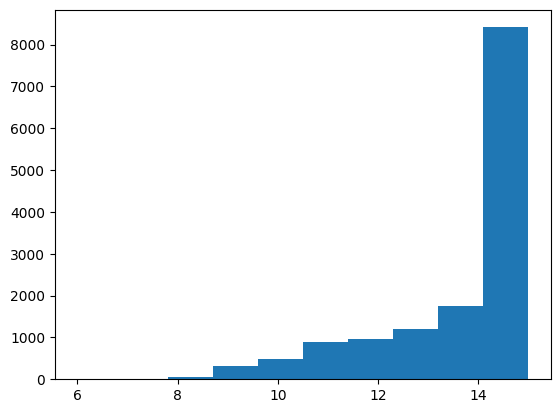

In [9]:
aaa = np.array([[1,2,3], [4,5,6], [7,8,9]])
tril_indices = np.tril_indices(3)
# aaa[tril_indices]

vec_pos = []
tril_indices = np.tril_indices(N_STOCKS)
for matrix in cov_matrices:
    ld_part = matrix[tril_indices]
    num_pos = np.sum(np.where(np.sign(ld_part) < 0, 0, 1))
    vec_pos.append(num_pos)

vec_pos = np.array(vec_pos)
plt.hist(vec_pos)

In [10]:
cholesky_vectors = calculate_hourly_realized_covariance(merged_df_minutely, freq='h', return_cholesky=True, transform=False)
print(f"Shape of Cholesky vectors: {cholesky_vectors.shape}")

Shape of Cholesky vectors: (14084, 15)


In [11]:
def calculate_mean_sign_accuracy(cholesky_vectors):
    def reconstruct_cov(cholesky_vec):
        """
        Reconstruct the covariance matrix from the Cholesky vector.
        """
        n = int((-1 + np.sqrt(1 + 8 * cholesky_vec.shape[1])) // 2)
        batch_size = cholesky_vec.shape[0]
        L = np.zeros((batch_size, n, n))
        tril_indices = np.tril_indices(n)
        for i in range(batch_size):
            L[i][tril_indices] = cholesky_vec[i]
        return np.matmul(L, np.transpose(L, axes=(0, 2, 1)))

    # Reconstruct covariance matrices
    true_cov = reconstruct_cov(cholesky_vectors)

    # Extract lower triangular part (including diagonal)
    tril_indices = np.tril_indices(true_cov.shape[1])

    # Calculate individual accuracies
    accuracies = []
    for i in range(true_cov.shape[0]):
        true_signs = np.sign(true_cov[i, tril_indices[0], tril_indices[1]])
        predicted_signs = np.ones_like(true_signs)  # Assume all positive
        accuracy = np.mean(true_signs == predicted_signs)
        accuracies.append(accuracy)

    # Return mean accuracy
    return np.mean(accuracies)

# Example usage
mean_accuracy = calculate_mean_sign_accuracy(cholesky_vectors)
print(f"Mean sign accuracy: {mean_accuracy:.4f}")
print("Accuracy is the accuracy of guessing the sign of the unique elements of the reconstructed covariance matrices. In this cell we suppose that we always predict the positive values of covariances")


Mean sign accuracy: 0.9260
Accuracy is the accuracy of guessing the sign of the unique elements of the reconstructed covariance matrices. In this cell we suppose that we always predict the positive values of covariances


In [12]:
# Step 6.1: Calculate Cholesky vectors
cholesky_vectors = calculate_hourly_realized_covariance(merged_df_minutely, freq='h', return_cholesky=True, transform=False)
print(f"Shape of Cholesky vectors: {cholesky_vectors.shape}")

# Optimal Parameters!!!!!
# hidden_size=128, sequence_length=14, lr=1e-05, penalty:1e-06

# Step 6.2: Prepare datasets and dataloaders
sequence_length = 7
train_dataset, test_dataset = prepare_data(cholesky_vectors, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
print(f"Length of train loader: {len(train_loader)*128}. Test: {len(test_loader)*128}")

# Step 6.3: Define model, loss function, and optimizer
input_size = cholesky_vectors.shape[1]  # Length of Cholesky vector
hidden_size = 465  # Can be tuned
output_size = cholesky_vectors.shape[1]


model = CholeskyLSTM(input_size, hidden_size, output_size, normalize=False)

criterion = FrobeniusLossWithSignPenalty(lambda_penalty=5e-07) ## winning 5e-07
# criterion = FrobeniusLoss() ## winning 5e-07
optimizer = torch.optim.Adam(model.parameters(), lr=1e-05) ## winning 1e-05

criterion1 = FrobeniusLossWithSignPenalty(lambda_penalty=5e-07)
criterion2 = FrobeniusLoss()
criterion3 = SignAccuracyLoss()

crit_dict = {'f_norm':criterion1, 'f_norm_pen':criterion2, 'acc':criterion3}

# Step 6.4: Train the model
cr_values = train_model(model, train_loader, criterion, optimizer, num_epochs=100, crit_dict=crit_dict)


Shape of Cholesky vectors: (14084, 15)
Length of train loader: 11264. Test: 2816
Epoch [1/100], Loss: 0.086471364
Epoch [2/100], Loss: 0.042522483
Epoch [3/100], Loss: 0.013799820
Epoch [4/100], Loss: 0.002529001
Epoch [5/100], Loss: 0.000388709
Epoch [6/100], Loss: 0.000133158
Epoch [7/100], Loss: 0.000074935
Epoch [8/100], Loss: 0.000054973
Epoch [9/100], Loss: 0.000051785
Epoch [10/100], Loss: 0.000051299
Epoch [11/100], Loss: 0.000051233
Epoch [12/100], Loss: 0.000051001
Epoch [13/100], Loss: 0.000050587
Epoch [14/100], Loss: 0.000050025
Epoch [15/100], Loss: 0.000049571
Epoch [16/100], Loss: 0.000049332
Epoch [17/100], Loss: 0.000049184
Epoch [18/100], Loss: 0.000049189
Epoch [19/100], Loss: 0.000049038
Epoch [20/100], Loss: 0.000049025
Epoch [21/100], Loss: 0.000049017
Epoch [22/100], Loss: 0.000048971
Epoch [23/100], Loss: 0.000048904
Epoch [24/100], Loss: 0.000048887
Epoch [25/100], Loss: 0.000048865
Epoch [26/100], Loss: 0.000048846
Epoch [27/100], Loss: 0.000048815
Epoch [28/

Text(0.5, 1.0, 'Accuracy of the guessed signs vs epoch')

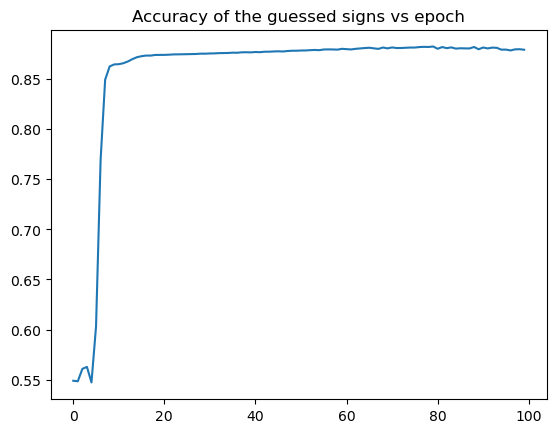

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(100), [1 - i.item() for i in cr_values['acc']])
plt.title("Accuracy of the guessed signs vs epoch")

Text(0.5, 1.0, 'Frobenious norm loss vs epoch')

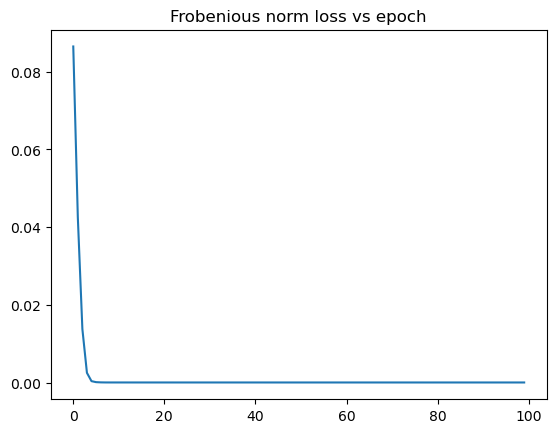

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(100), [i.item() for i in cr_values['f_norm']])
plt.title("Frobenious norm loss vs epoch")

In [15]:
# Step 6.5: Test the model
# Run testing
test_loss, predictions_test, targets_test = test_model(model, test_loader, criterion)

criterion1 = FrobeniusLossWithSignPenalty(lambda_penalty=5e-7)
criterion2 = FrobeniusLoss()
criterion3 = SignAccuracyLoss()

f_loss_pen = criterion1(predictions_test, targets_test)
f_loss = criterion2(predictions_test, targets_test)
acc = criterion3(predictions_test, targets_test)

print(f"accuracy: {1- acc}, f_loss: {f_loss}, f_loss_pen: {f_loss_pen}")

# Print shape of predictions and targets
print(f"Predictions shape: {predictions_test.shape}, Targets shape: {targets_test.shape}")

Test Loss: 0.0000
accuracy: 0.9172986745834351, f_loss: 1.6279720512102358e-05, f_loss_pen: 3.540334364515729e-05
Predictions shape: torch.Size([2815, 465]), Targets shape: torch.Size([2815, 465])


In [16]:
# See the results on the train set

train_loss, predictions_train, targets_train = test_model(model, train_loader, criterion)

criterion1 = FrobeniusLossWithSignPenalty(lambda_penalty=5e-7)
criterion2 = FrobeniusLoss()
criterion3 = SignAccuracyLoss()

f_loss_pen = criterion1(predictions_train, targets_train)
f_loss = criterion2(predictions_train, targets_train)
acc = criterion3(predictions_train, targets_train)

print(f"accuracy: {1- acc}, f_loss: {f_loss}, f_loss_pen: {f_loss_pen}")

# Print shape of predictions and targets
print(f"Predictions shape: {predictions_train.shape}, Targets shape: {targets_train.shape}")

Test Loss: 0.0000
accuracy: 0.8865141868591309, f_loss: 1.959801375051029e-05, f_loss_pen: 4.5792574383085594e-05
Predictions shape: torch.Size([11262, 465]), Targets shape: torch.Size([11262, 465])


In [17]:
count_pred_test = 0
count_trg_test = 0

n = 30

for index, pred_ in enumerate(predictions_test):
  pred = np.array(pred_)
  padded_arr = np.pad(pred, (0, n * (n + 1) // 2 - len(pred)), constant_values=0)

  # Create the lower triangular matrix
  lower_tri_matrix = np.zeros((n, n), dtype=pred.dtype)
  lower_tri_matrix[np.tril_indices(n)] = padded_arr
  cov_matrix = lower_tri_matrix @ lower_tri_matrix.T

  has_negative = (cov_matrix < 0).any()

  count_pred_test += has_negative

  pred = np.array(targets_test[index])
  padded_arr = np.pad(pred, (0, n * (n + 1) // 2 - len(pred)), constant_values=0)

  # Create the lower triangular matrix
  lower_tri_matrix = np.zeros((n, n), dtype=pred.dtype)
  lower_tri_matrix[np.tril_indices(n)] = padded_arr
  cov_matrix = lower_tri_matrix @ lower_tri_matrix.T

  has_negative = (cov_matrix < 0).any()
  
  count_trg_test += has_negative

print(f"Ratio of true covariance matrices with negative elements (on test set): {count_trg_test / len(predictions_test) * 100:.2f}% ")
print(f"Ratio of pred covariance matrices with negative elements (on test set): {count_pred_test / len(predictions_test) * 100:.2f}% ")


Ratio of true covariance matrices with negative elements (on test set): 77.23% 
Ratio of pred covariance matrices with negative elements (on test set): 46.39% 


In [18]:
count_pred_test = 0
count_trg_test = 0

for index, pred_ in enumerate(predictions_train):
  pred = np.array(pred_)
  padded_arr = np.pad(pred, (0, n * (n + 1) // 2 - len(pred)), constant_values=0)

  # Create the lower triangular matrix
  lower_tri_matrix = np.zeros((n, n), dtype=pred.dtype)
  lower_tri_matrix[np.tril_indices(n)] = padded_arr
  cov_matrix = lower_tri_matrix @ lower_tri_matrix.T

  has_negative = (cov_matrix < 0).any()

  count_pred_test += has_negative

  pred = np.array(targets_train[index])
  padded_arr = np.pad(pred, (0, n * (n + 1) // 2 - len(pred)), constant_values=0)

  # Create the lower triangular matrix
  lower_tri_matrix = np.zeros((n, n), dtype=pred.dtype)
  lower_tri_matrix[np.tril_indices(n)] = padded_arr
  cov_matrix = lower_tri_matrix @ lower_tri_matrix.T

  has_negative = (cov_matrix < 0).any()
  
  count_trg_test += has_negative

print(f"Ratio of true covariance matrices with negative elements (on test set): {count_trg_test / len(predictions_train) * 100:.2f}% ")
print(f"Ratio of pred covariance matrices with negative elements (on test set): {count_pred_test / len(predictions_train) * 100:.2f}% ")

Ratio of true covariance matrices with negative elements (on test set): 82.61% 
Ratio of pred covariance matrices with negative elements (on test set): 59.15% 


## Cross-Validation

In [21]:
cholesky_vectors.shape[1]

15

In [22]:
# def prepare_data1(data, sequence_length, train_ratio=0.9):
#     """
#     Split data into training and validation datasets.

#     The last `1 - train_ratio` fraction of the data is allocated to the validation set.
#     """
#     train_size = int(len(data) * train_ratio)
#     train_data = data[:train_size]
#     val_data = data[train_size:]

#     train_dataset = CholeskyDataset(train_data, sequence_length)
#     val_dataset = CholeskyDataset(val_data, sequence_length)

#     return train_dataset, val_dataset

# # Train Function
# def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, crit_dict=None):
#     if crit_dict is not None:
#         cr_values = {}
#         for key, cr in crit_dict.items():
#             cr_values[key] = []

#     train_losses = []
#     val_losses = []
#     for epoch in range(num_epochs):
#         # Training Loop
#         model.train()
#         # train_loss = 0
#         tr_predictions = []
#         tr_targets = []
#         for x, y in train_loader:
#             optimizer.zero_grad()
#             y_pred = model(x)
#             loss = criterion(y_pred, y)
#             loss.backward()
#             optimizer.step()
#             tr_predictions.append(y_pred)
#             tr_targets.append(y)
#             # train_loss += loss.item()
#         tr_predictions = torch.cat(tr_predictions, dim=0)
#         tr_targets = torch.cat(tr_targets, dim=0)
#         train_losses.append(criterion(tr_predictions, tr_targets).item())

#         # Validation Loop
#         model.eval()
#         # val_loss = 0
#         all_predictions = []
#         all_targets = []
#         with torch.no_grad():
#             for x, y in val_loader:
#                 y_pred = model(x)
#                 all_predictions.append(y_pred)
#                 all_targets.append(y)
#                 # loss = criterion(y_pred, y)
#                 # val_loss += loss.item()

#         all_predictions = torch.cat(all_predictions, dim=0)
#         all_targets = torch.cat(all_targets, dim=0)
        
#         val_losses.append(criterion(all_predictions, all_targets).item())

#         if crit_dict is not None:
#             for key, cr in crit_dict.items():
#                  cr_values[key].append(cr(all_predictions, all_targets).item())
    
#     return train_losses, val_losses, cr_values

# if __name__ == "__main__":
#     cholesky_vectors1 = cholesky_vectors[:11264]
#     num_epochs = 80
#     batch_size = 64

#     sequence_lengths = [7, 14]
#     hidden_sizes = [64, 128, 465]#[15, 32, 64, 128]
#     learning_rates = [0.0001, 0.00001]
#     penalties = [1e-6, 5e-7, 1e-7]
#     results = {}

#     for hidden_size in hidden_sizes:
#         for sequence_length in sequence_lengths:
#             for lr in learning_rates:
#                 for penalty in penalties:
#                     print(f"Running experiment: hidden_size={hidden_size}, sequence_length={sequence_length}, lr={lr}, penalty:{penalty}")

#                     # Prepare train and validation datasets
#                     train_dataset, val_dataset = prepare_data1(cholesky_vectors1, sequence_length)
#                     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#                     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#                     input_size = cholesky_vectors1.shape[1]
#                     output_size = cholesky_vectors1.shape[1]
#                     model = CholeskyLSTM(input_size, hidden_size, output_size)
#                     criterion = FrobeniusLossWithSignPenalty(lambda_penalty=penalty)
#                     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#                     criterion1 = FrobeniusLossWithSignPenalty(lambda_penalty=penalty)
#                     criterion2 = FrobeniusLoss()
#                     criterion3 = SignAccuracyLoss()

#                     crit_dict = {'f_norm':criterion1, 'f_norm_pen':criterion2, 'acc':criterion3}


#                     train_losses, val_losses, cr_values = train_and_validate(
#                         model, train_loader, val_loader, criterion, optimizer, num_epochs, crit_dict
#                     )

#                     # Store results
#                     key = f"hidden_size={hidden_size}, sequence_length={sequence_length}, lr={lr}, penalty:{penalty}"
#                     results[key] = (train_losses, val_losses, cr_values)

#                     # Plot results
#                     # plt.figure()
#                     # plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
#                     # plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
#                     # plt.title(f"Loss Curves: {key}")
#                     # plt.xlabel('Epoch')
#                     # plt.ylabel('Loss')
#                     # plt.legend()
#                     # plt.show()


In [23]:
# plt.plot(results['hidden_size=1028, sequence_length=35, lr=0.0001, penalty:5e-06'][2]['f_norm'][10:])

In [24]:
# plt.plot(results['hidden_size=15, sequence_length=35, lr=0.0001, penalty:5e-06'][2]['acc'][10:])

In [25]:
# np.mean(results['hidden_size=15, sequence_length=35, lr=0.0001, penalty:5e-06'][2]['acc'][-10:])
# np.mean(results['hidden_size=15, sequence_length=35, lr=0.0001, penalty:5e-06'][2]['f_norm'][-10:])
# np.mean(results['hidden_size=15, sequence_length=35, lr=0.0001, penalty:5e-06'][2]['f_norm_pen'][-10:])

In [26]:
# res_df = pd.DataFrame(columns=['f_norm', 'f_norm_pen', 'acc'])
# for key, val in results.items():
#     f_norm_mean, f_norm_pen_mean, acc_mean = np.mean(val[2]['f_norm'][-5:]), np.mean(val[2]['f_norm_pen'][-5:]), np.mean(val[2]['acc'][-5:])
#     res_df.loc[key] = {'f_norm':f_norm_mean, 'f_norm_pen':f_norm_pen_mean, 'acc':acc_mean}

# res_df.head()

In [27]:
# res_df.sort_values(['acc']).head(20)